In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers, models, Input

2021-11-12 10:41:08.974265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-12 10:41:08.974294: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load Data

In [2]:
x_train = np.load("./data/Xtrain_Classification_Part2.npy")
y_train = np.load("./data/Ytrain_Classification_Part2.npy")
x_test = np.load("./data/Xtest_Classification_Part2.npy")

In [15]:
image1_5050 = np.reshape(image_1,(50,50))

# Tensorflow

## Multi Layer Perpectron

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 2500)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              2501000   
_________________________________________________________________
dense_13 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 4004      
Total params: 3,506,004
Trainable params: 3,506,004
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
295/295 [==============================] - 5s 15ms/step - loss: 1.0423 - accuracy: 0.6086 - val_loss: 0.8721 - val_accuracy: 0.6682
Epoch 2/20
295/295 [==============================] - 5s 15ms/step - loss: 0.8068 - accuracy: 0.696

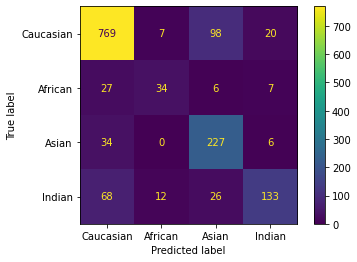

In [7]:
train_x, test_x, train_y, test_y  = train_test_split(x_train, y_train, test_size=0.2)

train_y_cat = tf.keras.utils.to_categorical(train_y, 4)
test_y_cat = tf.keras.utils.to_categorical(test_y, 4)

# trainar o modelo:
# Input scaled from (0, 255) to a range of (0, +1.)
mlp = models.Sequential()
mlp.add(Input(shape=(2500,)))
mlp.add(layers.Rescaling(scale=1 / 255))          # scale 0-255 to 0-1
mlp.add(layers.Dense(1000, activation="relu"))
mlp.add(layers.Dense(1000, activation="relu"))
#if softmax is chosen, the model will have more parameters that need to learn
mlp.add(layers.Dense(4, activation="softmax"))    # output layer
mlp.summary()
mlp.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
history = mlp.fit(train_x, train_y_cat, epochs=20, batch_size=20,
                    validation_data=(test_x, test_y_cat))

# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

y_hat_test_cat = mlp.predict(test_x)
y_hat_test = np.argmax(y_hat_test_cat, axis=-1)
#test_loss, test_acc = mlp.evaluate(test_x,  test_y, verbose=2)

ConfusionMatrixDisplay.from_predictions(test_y, y_hat_test,display_labels=["Caucasian", "African", "Asian", "Indian"])

bacc = balanced_accuracy_score(test_y, y_hat_test)

print("BACC(MLP):", bacc)
print("Y_hat shape:", y_hat_test.shape)

BACC = 0.809608093469514


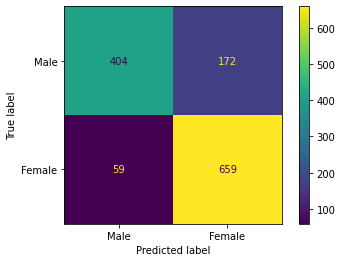

In [8]:
y_hat = (mlp.predict(test_x) > 0.5).astype("int32")
bacc = balanced_accuracy_score(test_y, y_hat)
ConfusionMatrixDisplay.from_predictions(test_y, y_hat, display_labels=["Male", "Female"])
print(f"BACC = {bacc}")

## Deep Neural Network

Epoch 1/20
93/93 [==============================] - 3s 30ms/step - loss: 1.0701 - categorical_accuracy: 0.6010 - val_loss: 0.9864 - val_categorical_accuracy: 0.6242
Epoch 2/20
93/93 [==============================] - 3s 35ms/step - loss: 0.9470 - categorical_accuracy: 0.6152 - val_loss: 0.8575 - val_categorical_accuracy: 0.6900
Epoch 3/20
93/93 [==============================] - 4s 43ms/step - loss: 0.8034 - categorical_accuracy: 0.6872 - val_loss: 0.8233 - val_categorical_accuracy: 0.6872
Epoch 4/20
93/93 [==============================] - 4s 44ms/step - loss: 0.7203 - categorical_accuracy: 0.7227 - val_loss: 0.7166 - val_categorical_accuracy: 0.7286
Epoch 5/20
93/93 [==============================] - 4s 44ms/step - loss: 0.6682 - categorical_accuracy: 0.7478 - val_loss: 0.6338 - val_categorical_accuracy: 0.7680
Epoch 6/20
93/93 [==============================] - 4s 42ms/step - loss: 0.6249 - categorical_accuracy: 0.7634 - val_loss: 0.6404 - val_categorical_accuracy: 0.7666
Epoch 7/20

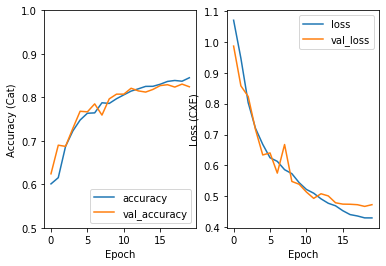

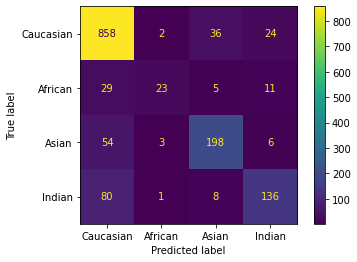

In [14]:
train_x, test_x, train_y, test_y  = train_test_split(x_train, y_train, test_size=0.2)

train_x = np.reshape(train_x, (len(train_x), 50, 50, 1))
test_x = np.reshape(test_x, (len(test_x),50, 50, 1))

train_y_cat = tf.keras.utils.to_categorical(train_y, 4)
test_y_cat = tf.keras.utils.to_categorical(test_y, 4)

# learning step
def ln_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

ln_callback = tf.keras.callbacks.LearningRateScheduler(ln_scheduler)
# testar com outro monitor = "bacc"
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)  #restore_best_weights = False
# kernel size (3,5,7)
# batch size

model = models.Sequential()
model.add(Input(shape=(50, 50, 1)))
model.add(layers.Rescaling(scale=1 / 255))          # scale 0-255 to 0-1
model.add(layers.Conv2D(12, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Dropout(0.2))
# Flatten
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dropout(0.3))
model.add(layers.Dense(4, activation="softmax"))
#model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

history = model.fit(train_x, train_y_cat, epochs=20, batch_size=64,
                    validation_data=(test_x, test_y_cat), callbacks=[earlystop , ln_callback])

# Evaluate the model

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['categorical_accuracy'], label='accuracy')
ax1.plot(history.history['val_categorical_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (Cat)')
ax1.set_ylim([0.5, 1])
ax1.legend(loc='lower right')

ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label = 'val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss (CXE)')
ax2.legend(loc='upper right')

# test_loss, test_acc = model.evaluate(test_x,  test_y, verbose=2)
# print(f"Test Loss: {test_loss:.3f} Test Accuracy {test_acc:.3f}")

y_hat_test_cat = model.predict(test_x)
y_hat_test = np.argmax(y_hat_test_cat, axis=-1)
#test_loss, test_acc = mlp.evaluate(test_x,  test_y, verbose=2)

ConfusionMatrixDisplay.from_predictions(test_y, y_hat_test,display_labels=["Caucasian", "African", "Asian", "Indian"])

bacc = balanced_accuracy_score(test_y, y_hat_test)

print(f"BACC = {bacc:.3f}")
print("Y_hat shape:", y_hat_test.shape)


In [11]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

# Predição FINAL

In [13]:
# predições
print("Test input shape", x_test.shape)
x_test_50_50 = np.reshape(x_test, (len(x_test),50, 50, 1))
y_hat = (model.predict(x_test_50_50) > 0.5).astype("int32")
print("Test output shape", y_hat.reshape(-1).shape)
np.save("y_hat_classification_prob1.npy", y_hat.reshape(-1))

Test input shape (1164, 2500)
Test output shape (1164,)


In [14]:
# Validação de shapes
load_y_hat = np.load("y_hat_classification_prob1.npy")
print("Load shape", load_y_hat.shape)

Load shape (1164,)
